Вы выбрали Dataset из списка, проведите полный цикл работы над вашим проектом, что проходили ранее.

Рекомендации:
*   Соблюдайте PEP8
*   Комментируйте код в местах, где конструкция большая
*   Оставляйте промежуточные выводы по вашему исследованию и построению модели (так кураторам будет проще понять ваши заключения)
*   Экспериментируйте! Вы не ограничены в моделях и подходах. Можете использовать любые DS инструменты (и те, которые мы не разбирали с вами на курсе)

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from scipy.stats import uniform

from tensorflow import keras
from keras.models import Sequential # Подлючаем класс создания модели Sequential
from keras.layers import Dense, Dropout, Flatten, MaxPooling1D # Подключаем класс Dense - полносвязный слой, и Flatten - данные выстраиваем в линию, одномерные
from keras.optimizers import Adam # Подключаем оптимизатор Adam

In [2]:
pd.set_option('display.max_columns', None) #Этой строкой я включаю отображение всех колонок в VS Code
pd.set_option('display.max_colwidth', None) #Этой строкой я включаю отображение всех символов в строке

# 1. Загрузка и предобработка данных

Сначала загрузим наш датасет:

In [3]:
df = pd.read_csv('final_Base.csv', delimiter=',')
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,10650.765523,3134.319630,3863.647740,1,6,CA,185,0,BA,1,0,24,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,534.047319,2670.918292,3124.298166,718,3,CA,259,1,BA,0,0,15,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,4048.534263,2893.621498,3159.590679,1,14,CB,177,1,BA,0,1,-1,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,3457.064063,4054.908412,3022.261812,1921,6,CA,110,1,BA,0,1,31,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,5020.341679,2728.237159,3087.670952,1990,2,CA,295,1,BA,1,0,31,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7


Посмотрим на информацию о нашем датасете:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

Посмотрим значения всех колонок:

*   fraud_bool - Ярлык мошенничества (1, если мошенничество, 0, если законно)
*   income - Годовой доход заявителя в количественных показателях. Колеблется в пределах [0, 1].
*   name_email_similarity - Показатель сходства между адресом электронной почты и именем заявителя. Более высокие значения означают более высокое сходство. Колеблется в пределах [0, 1].
*   prev_address_months_count - Количество месяцев по предыдущему зарегистрированному адресу заявителя, т.е. предыдущему месту жительства заявителя, если применимо. Колеблется в пределах [-1, 380] месяцев (-1 - пропущенное значение).
*   current_address_months_count - Месяцев по текущему зарегистрированному адресу заявителя. Колеблется в пределах [-1, 406] месяцев (-1 - пропущенное значение).
*   customer_age - Возраст заявителя в ячейках за десятилетие (например, 20-29 представлены как 20).
*   days_since_request - Количество дней, прошедших с момента подачи заявки. Колеблется в пределах [0, 78] дней.
*   intended_balcon_amount - Первоначальная переведенная сумма для подачи заявки. Колеблется в пределах [-1, 108].
*   payment_type - Тип кредитного плана оплаты. 5 возможных (анонимизированных) значений.
*   zip_count_4w - Количество заявок в пределах одного и того же почтового индекса за последние 4 недели. Колеблется в пределах [1, 5767].
*   velocity_6h - Скорость общего количества заявок, поданных за последние 6 часов, т.е. среднее количество заявок в час за последние 6 часов. Колеблется между [-211, 24763].
*   velocity_24h - Скорость общего количества заявок, поданных за последние 24 часа, т.е. среднее количество заявок в час за последние 24 часа. Колеблется между [1329, 9527].
*   velocity_4w - Скорость общего количества заявок, поданных за последние 4 недели, т.е. среднее количество заявок в час за последние 4 недели. Колеблется между [2779, 7043].
*   bank_branch_count_8w - Общее количество заявок в выбранном отделении банка за последние 8 недель. Колеблется в пределах [0, 2521].
*   date_of_birth_distinct_emails_4w - Количество электронных писем для заявителей с одинаковой датой рождения за последние 4 недели. Колеблется в пределах [0, 42].
*   employment_status - Трудовой статус заявителя. 7 возможных (анонимизированных) значений.
*   credit_risk_score - Внутренняя оценка риска применения. Колеблется между [-176, 387].
*   email_is_free - Домен электронной почты приложения (бесплатный или платный). 
*   housing_status - Текущий статус проживания заявителя. 7 возможных (анонимизированных) значений.
*   phone_home_valid - Срок действия предоставленного домашнего телефона.
*   phone_mobile_valid - Срок действия предоставленного мобильного телефона. 
*   bank_months_count - Сколько лет предыдущему аккаунту (если он был открыт) в месяцах. Колеблется между [-1, 31] месяцами (-1 - пропущенное значение). 
*   has_other_cards - Если у заявителя есть другие карты от той же банковской компании.
*   proposed_credit_limit - Предлагаемый заявителем кредитный лимит. Колеблется между [200, 2000].
*   foreign_request - Если страна происхождения запроса отличается от страны банка.
*   source - Онлайн-источник заявки. Либо браузер (INTERNET), либо мобильное приложение (APP).
*   session_length_in_minutes - Продолжительность сеанса пользователя на банковском веб-сайте в минутах. Колеблется в пределах [-1, 107] минут
*   device_os - Операционная система устройства, сделавшего запрос. Возможные значения: Windows, Macintox, Linux, X11 или другие.
*   keep_alive_session - Пользовательская опция при выходе из сеанса.
*   device_distinct_emails_8w - Количество отдельных электронных писем на банковском веб-сайте с используемого устройства за последние 8 недель. Колеблется в пределах [0, 3].
*   device_fraud_count - Количество мошеннических приложений с использованным устройством. Колеблется в пределах [0, 1].
*   month - Месяц, в течение которого было подано заявление. Колеблется в пределах [0, 7].

In [5]:
df.isna().sum()

fraud_bool                          0
income                              0
name_email_similarity               0
prev_address_months_count           0
current_address_months_count        0
customer_age                        0
days_since_request                  0
intended_balcon_amount              0
payment_type                        0
zip_count_4w                        0
velocity_6h                         0
velocity_24h                        0
velocity_4w                         0
bank_branch_count_8w                0
date_of_birth_distinct_emails_4w    0
employment_status                   0
credit_risk_score                   0
email_is_free                       0
housing_status                      0
phone_home_valid                    0
phone_mobile_valid                  0
bank_months_count                   0
has_other_cards                     0
proposed_credit_limit               0
foreign_request                     0
source                              0
session_leng

И проверим дубликаты:

In [6]:
df[df.duplicated()]

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month


*Дубликатов и пропусков не обнаружено.*

*Пока мы не будем переводить категориальные переменные, сделаем это после описательного анализа*

### ВЫВОД ПО П.1:   
**Что мы можем сказать о нашем DataFrame:**
*   Всего записей 1000000, пропусков и дубликатов нет
*   32 колонки, из них 9 - float64, 19 - int64, 5 - object
*   Обьем занимаемой памяти - 244.1+ MB

# 2. Описательный анализ данных, просмотр данных и вывод статистики

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fraud_bool,1000000.0,0.011029,0.104438,0.000000e+00,0.000000,0.000000,0.000000,1.000000
income,1000000.0,0.562696,0.290343,1.000000e-01,0.300000,0.600000,0.800000,0.900000
name_email_similarity,1000000.0,0.493694,0.289125,1.434550e-06,0.225216,0.492153,0.755567,0.999999
prev_address_months_count,1000000.0,16.718568,44.046230,-1.000000e+00,-1.000000,-1.000000,12.000000,383.000000
current_address_months_count,1000000.0,86.587867,88.406599,-1.000000e+00,19.000000,52.000000,130.000000,428.000000
customer_age,1000000.0,33.689080,12.025799,1.000000e+01,20.000000,30.000000,40.000000,90.000000
days_since_request,1000000.0,1.025705,5.381835,4.036860e-09,0.007193,0.015176,0.026331,78.456904
intended_balcon_amount,1000000.0,8.661499,20.236155,-1.553055e+01,-1.181488,-0.830507,4.984176,112.956928
zip_count_4w,1000000.0,1572.692049,1005.374565,1.000000e+00,894.000000,1263.000000,1944.000000,6700.000000
velocity_6h,1000000.0,5665.296605,3009.380665,-1.706031e+02,3436.365848,5319.769349,7680.717827,16715.565404


*   fraud_bool (Ярлык мошенничества) - Чаще встречаются не мошеннические действия
*   income (Годовой доход заявителя) - Среднее 0.56
*   name_email_similarity (Показатель сходства между адресом электронной почты и именем заявителя) - Среднее 0.49
*   prev_address_months_count (Количество месяцев по предыдущему зарегистрированному адресу заявителя) - Среднее 16.72
*   current_address_months_count (Месяцев по текущему зарегистрированному адресу заявителя) - Среднее 86.59
*   customer_age (Возраст заявителя) - Медиана 30
*   days_since_request (Количество дней, прошедших с момента подачи заявки) - Среднее 1.02
*   intended_balcon_amount (Первоначальная переведенная сумма для подачи заявки) - Среднее 8.66
*   zip_count_4w (Количество заявок в пределах одного и того же почтового индекса) - Среднее 1572.69
*   velocity_6h (Скорость общего количества заявок, поданных за последние 6 часов) - Среднее 5665.3
*   velocity_24h (Скорость общего количества заявок, поданных за последние 24 часа) - Среднее 4769.78
*   velocity_4w (Скорость общего количества заявок, поданных за последние 4 недели) - Среднее 4856.32
*   bank_branch_count_8w (Общее количество заявок в выбранном отделении банка за последние 8 недель) - Среднее 184.36
*   date_of_birth_distinct_emails_4w (Количество электронных писем для заявителей с одинаковой датой рождения за последние 4 недели) - Среднее 9.50
*   credit_risk_score (Внутренняя оценка риска применения) - Среднее 131
*   email_is_free (Домен электронной почты приложения) - Среднее 0.53
*   phone_home_valid (Срок действия предоставленного домашнего телефона) - Среднее 0.42
*   phone_mobile_valid (Срок действия предоставленного мобильного телефона) - Среднее 0.89
*   bank_months_count (Сколько лет предыдущему аккаунту) - Среднее 10.84
*   has_other_cards (Если у заявителя есть другие карты от той же банковской компании) - Среднее 0.22
*   proposed_credit_limit (Предлагаемый заявителем кредитный лимит) - Среднее 515.85
*   foreign_request (Если страна происхождения запроса отличается от страны банка) - Среднее 0.03
*   session_length_in_minutes (Продолжительность сеанса пользователя на банковском веб-сайте в минутах) - Среднее 7.54
*   keep_alive_session (Пользовательская опция при выходе из сеанса) - Среднее 0.58
*   device_distinct_emails_8w (Количество отдельных электронных писем на банковском веб-сайте с используемого устройства за последние 8 недель) - Среднее 1.02
*   device_fraud_count (Количество мошеннических приложений с использованным устройством) - Значения только 0
*   month (Месяц, в течение которого было подано заявление) - Среднее 3.29

In [8]:
df.describe(include='object').T

,count,unique,top,freq
payment_type,1000000,5,AB,370554
employment_status,1000000,7,CA,730252
housing_status,1000000,7,BC,372143
source,1000000,2,INTERNET,992952
device_os,1000000,5,other,342728


*   payment_type (Тип платежа) - 5 уникальных значений, чаще встречается AB
*   employment_status (Трудовой статус заявителя. ) - 7 уникальных значений, чаще встречается CA
*   housing_status (Текущий статус проживания заявителя) - 7 уникальных значений, чаще встречается BC
*   source (Онлайн-источник заявки) - 2 уникальных значения, чаще встречается INTERNET
*   device_os (Операционная система устройства) - 5 уникальных значений, чаще встречается other

**Посмотрим распределение данных по целевому признаку:**

In [9]:
df['fraud_bool'].value_counts()

fraud_bool
0    988971
1     11029
Name: count, dtype: int64

In [10]:
print('Процент мошеннических действий:  ' , round((11029 / 1000000) * 100 , 100) , '%')

Процент мошеннических действий:   1.1029 %


### ВЫВОД ПО П.2:
В данных нет пропусков и дубликатов. В целом мы имеем большое количество данных для нашей модели, правда записей о мошеннеческих действиях у нас всего 1.1% от общего числа, мы это используем позже, при определении весов в модели.

**Теперь время провести преобразования**

In [5]:
df = pd.get_dummies(df, columns=['payment_type', 'employment_status', 'housing_status', 'source', 'device_os'], dtype=int)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 53 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   zip_count_4w                      1000000 non-null  int64  
 9   velocity_6h                       1000000 non-null  float64
 10  velocity_24h                      1000000 non-null  float64
 11  velocity_4w                       1000

**Теперь у нас все данные имеют тип int или float**

# 3. Постройте необходимые графики для анализа

Посмотрим графики для всей выборки:

Text(0.5, 0, ' ')

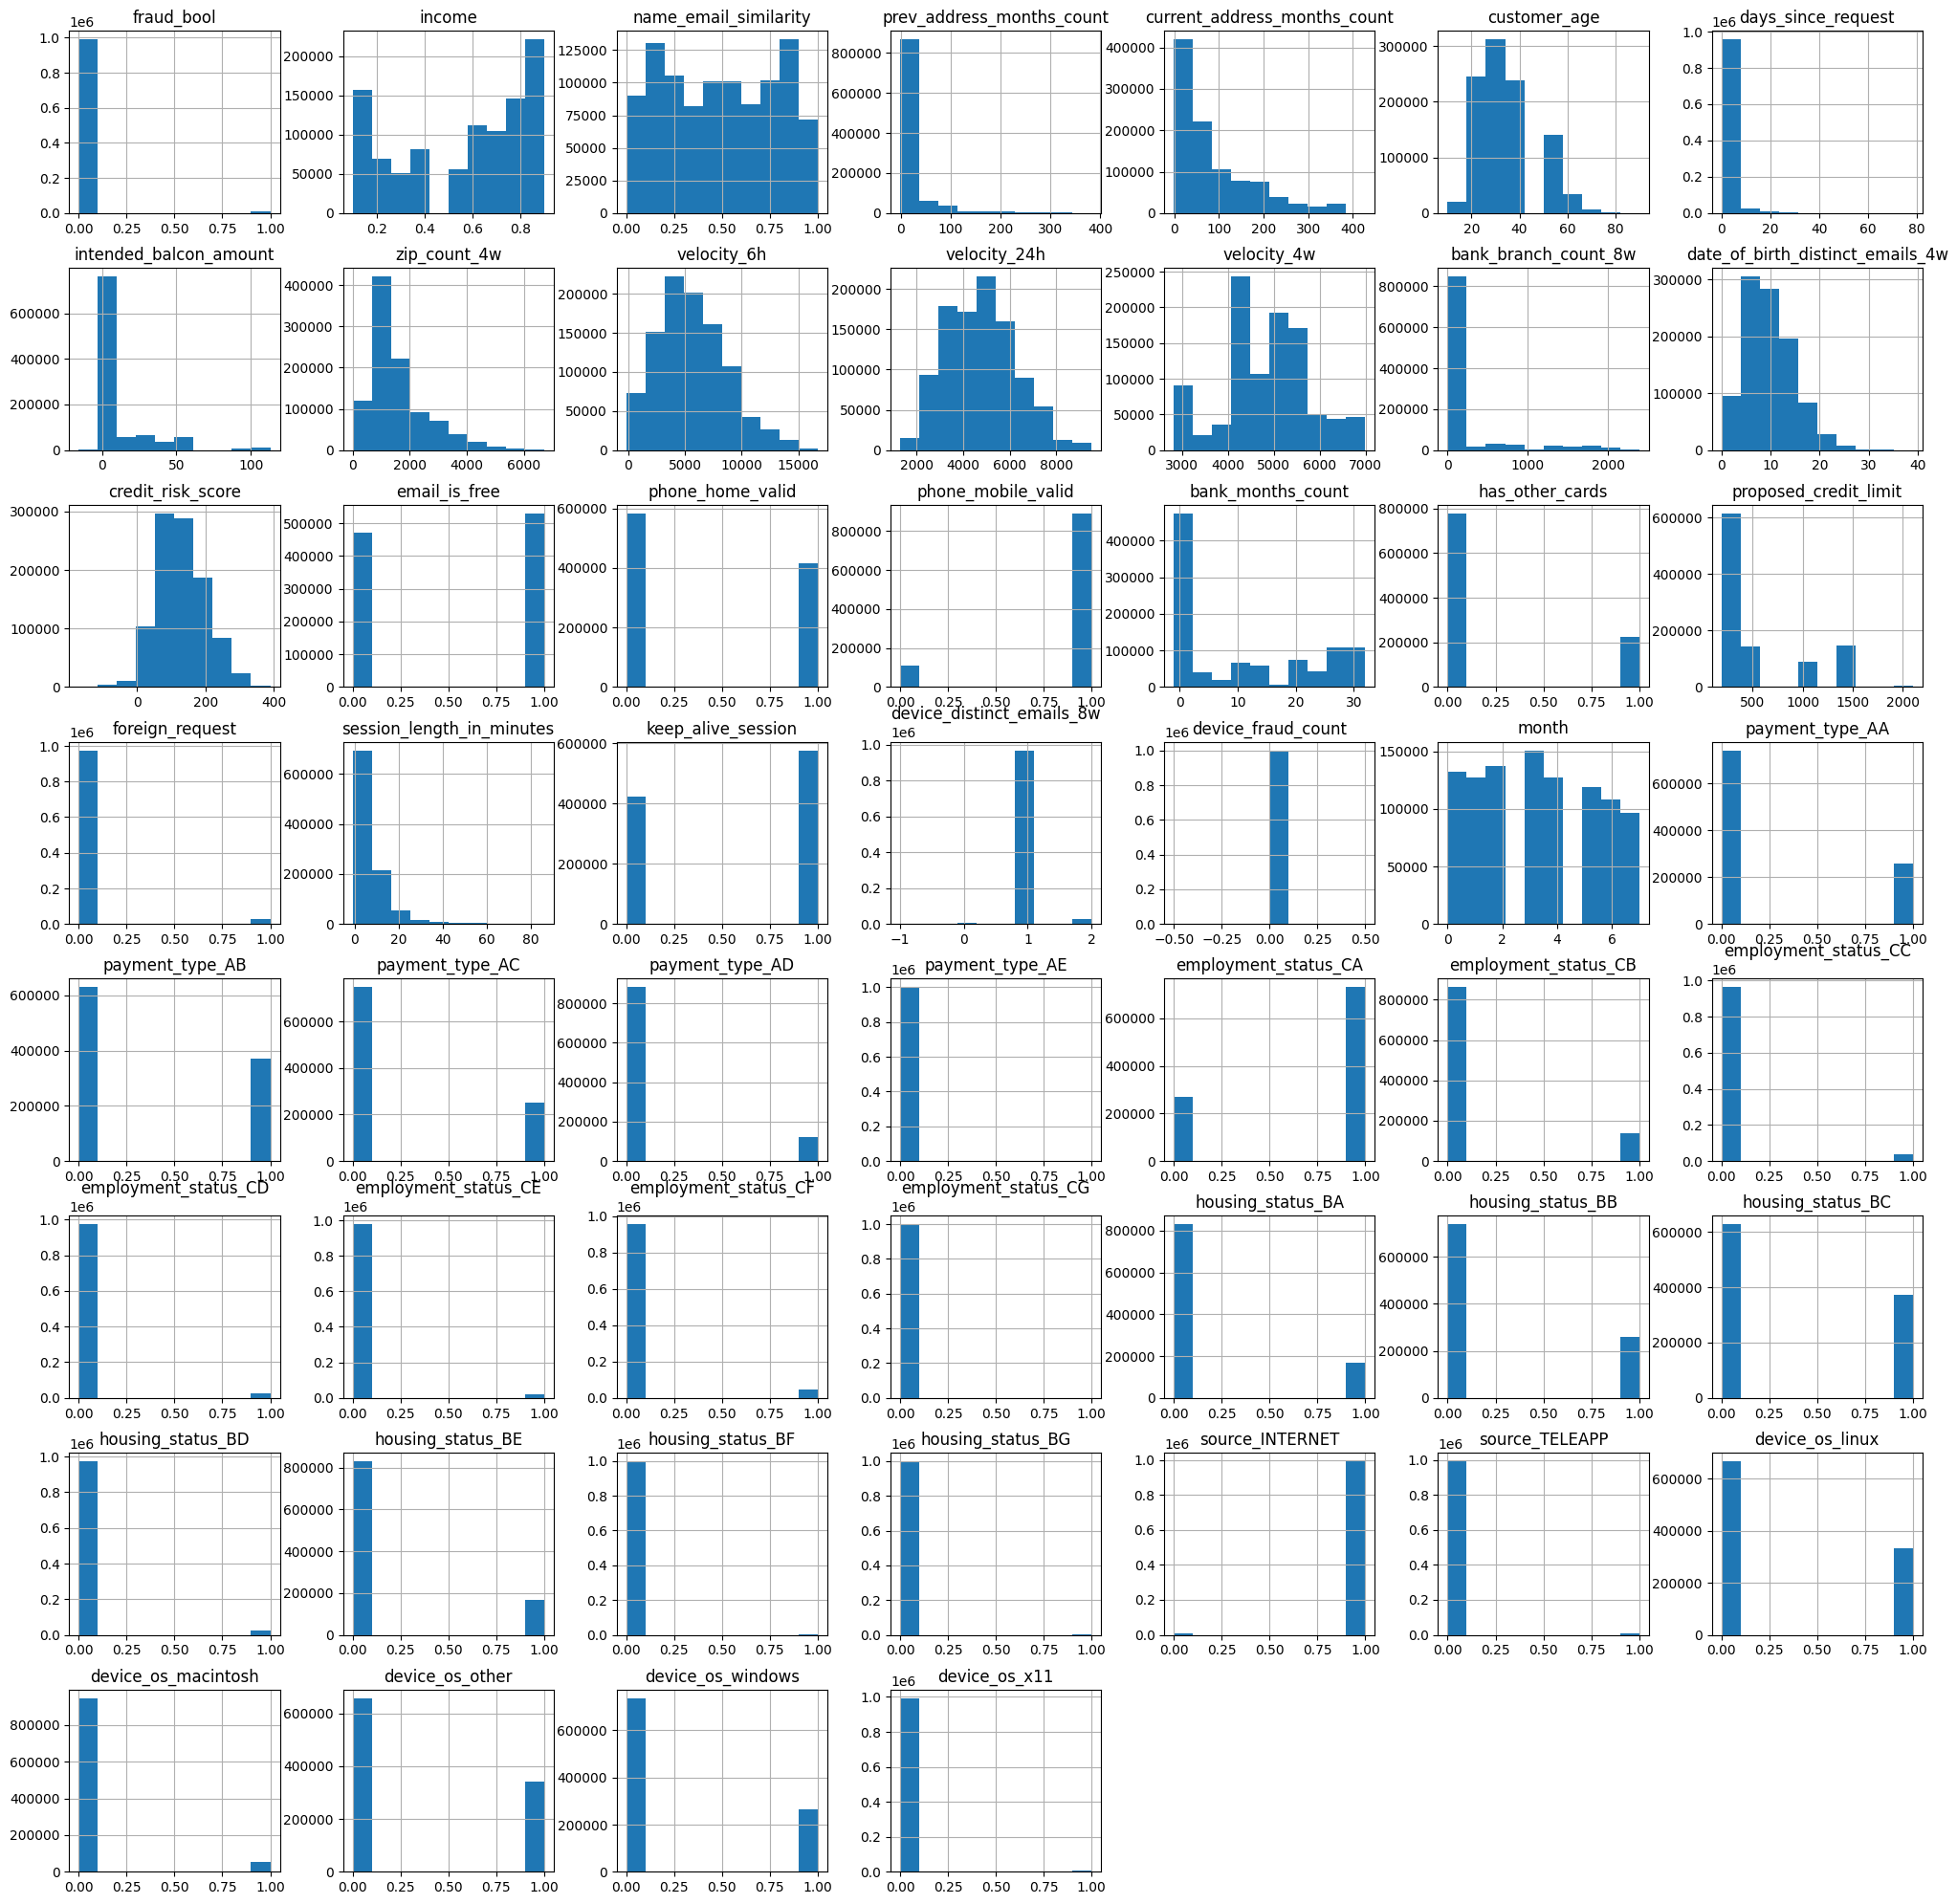

In [71]:
df.hist(figsize=(25,25))
plt.xlabel(' ')

Что мы видим из графиков:

*   Данные о мошенничестве - fraud_bool (целевой признак) - "1" мало, но мы это знали и до этого
*   Больше половины имеют доход выше 0.5
*   Большее количество клиентов проживают на текущем адресе от 0 до 100 месяцев, тогда как на предыдущем от 0 до 40
*   Большее количество клиентов имеют возраст от 20 до 40(49) лет
*   Количество дней, прошедших с момента подачи заявки до 1
*   Первоначальная переведенная сумма для подачи заявки у большинства клиентов от 0 до 10
*   Количество заявок в пределах одного и того же почтового индекса от 0 до 2000
*   Скорость общего количества заявок у большинства записей от 3000 до 6000
*   Общее количество заявок в выбранном отделении банка за последние 8 недель у большинства записей от 0 до 100
*   Количество электронных писем для заявителей с одинаковой датой рождения за последние 4 недели у большинства записей от 0 до 15
*   Внутренняя оценка риска применения у большинства записей от 0 до 200
*   У большинства клиентов бесплатный e-mail
*   Срок действия мобильных телефонов у большинства выше, чем те же показатели у домашних телефонов
*   Чаще встречаются клиенты у которых срок предыдущего аккаунта от 0 до 2 месяцев
*   Чаще у клиентов нет других карт
*   Предлагаемый заявителем кредитный лимит у большинства клиентов от 0 до 400
*   Чаще страна происхождения клиентов не отличается от страны регистрации банка
*   Клиенты чаще не находятся на банковском сайте дольше 20 минут
*   Количество мошеннических приложений с использованным устройством 0 
*   Чаще использованный тип платежа AB
*   Чаще трудовой статус заявителя - CA
*   Чаще текущий статус проживания заявителя - BC
*   Чаще онлайн-источник заявки - INTERNET
*   Чаще операционная система устройства - other

Так же мы можем на графики вывести устройства, с которых были произведены мошеннические действия:

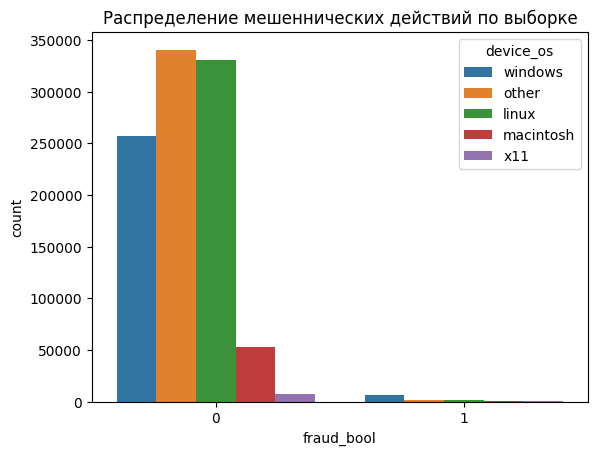

In [68]:
sns.countplot(x='fraud_bool', hue='device_os', data=df)
plt.title('Распределение мошеннических действий по выборке')
plt.show()
# График создан до get_dummies для читаемости

**Т.е. получается, что чаще мошенники выбирали Windows**

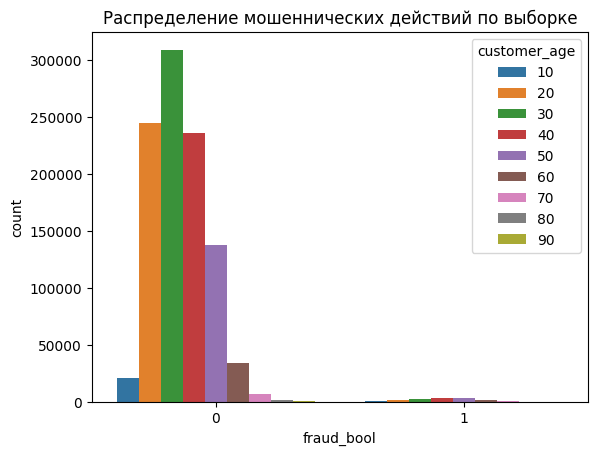

In [73]:
sns.countplot(x='fraud_bool', hue='customer_age', data=df)
plt.title('Распределение мошеннических действий по выборке')
plt.show()

**Чаще ярлык мошенника получали от 40 до 59 лет**

Все остальное мы посмотрим на матрице корреляции

Также мы можем посмотреть выбросы:

<Axes: title={'center': 'Выбросы'}>

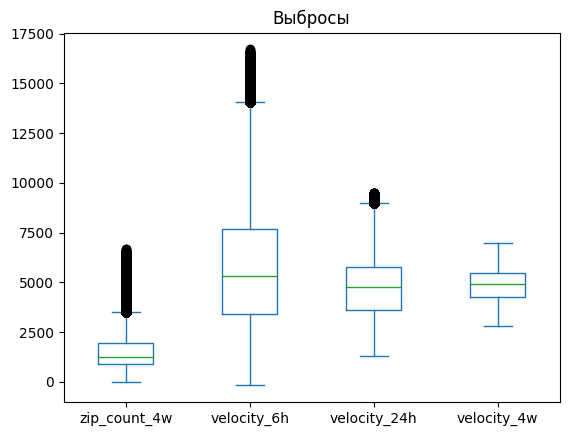

In [43]:
df[['zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w']].plot.box(title='Выбросы')

<Axes: title={'center': 'Выбросы'}>

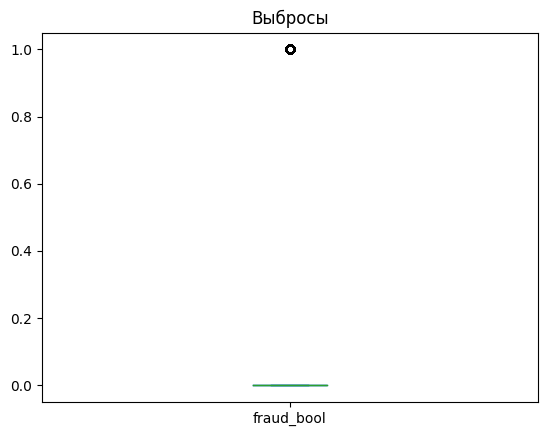

In [44]:
df[['fraud_bool']].plot.box(title='Выбросы')

В целом, выбросы определяются, но мы не будем их удалять, а построим модель на данных, которые есть, так как мы можем убрать и без того небольшое количество мошеннических транзакций.

### ВЫВОД ПО П.3:
Мы посмотрели общие графики и сделали выводы по каждому пункту, посмотрели выбросы. Но интереснее всего графики с разделением на мошеннические действия, так мы узнали:
*   Чаще они совершались с Windows
*   Чаще ярлык мошенника получали от 40 до 59 лет

# 4. Проверьте гипотезы (если потребуется)

**Мы не будем строить гипотезы, а просто посмотрим корреляции**

<Axes: >

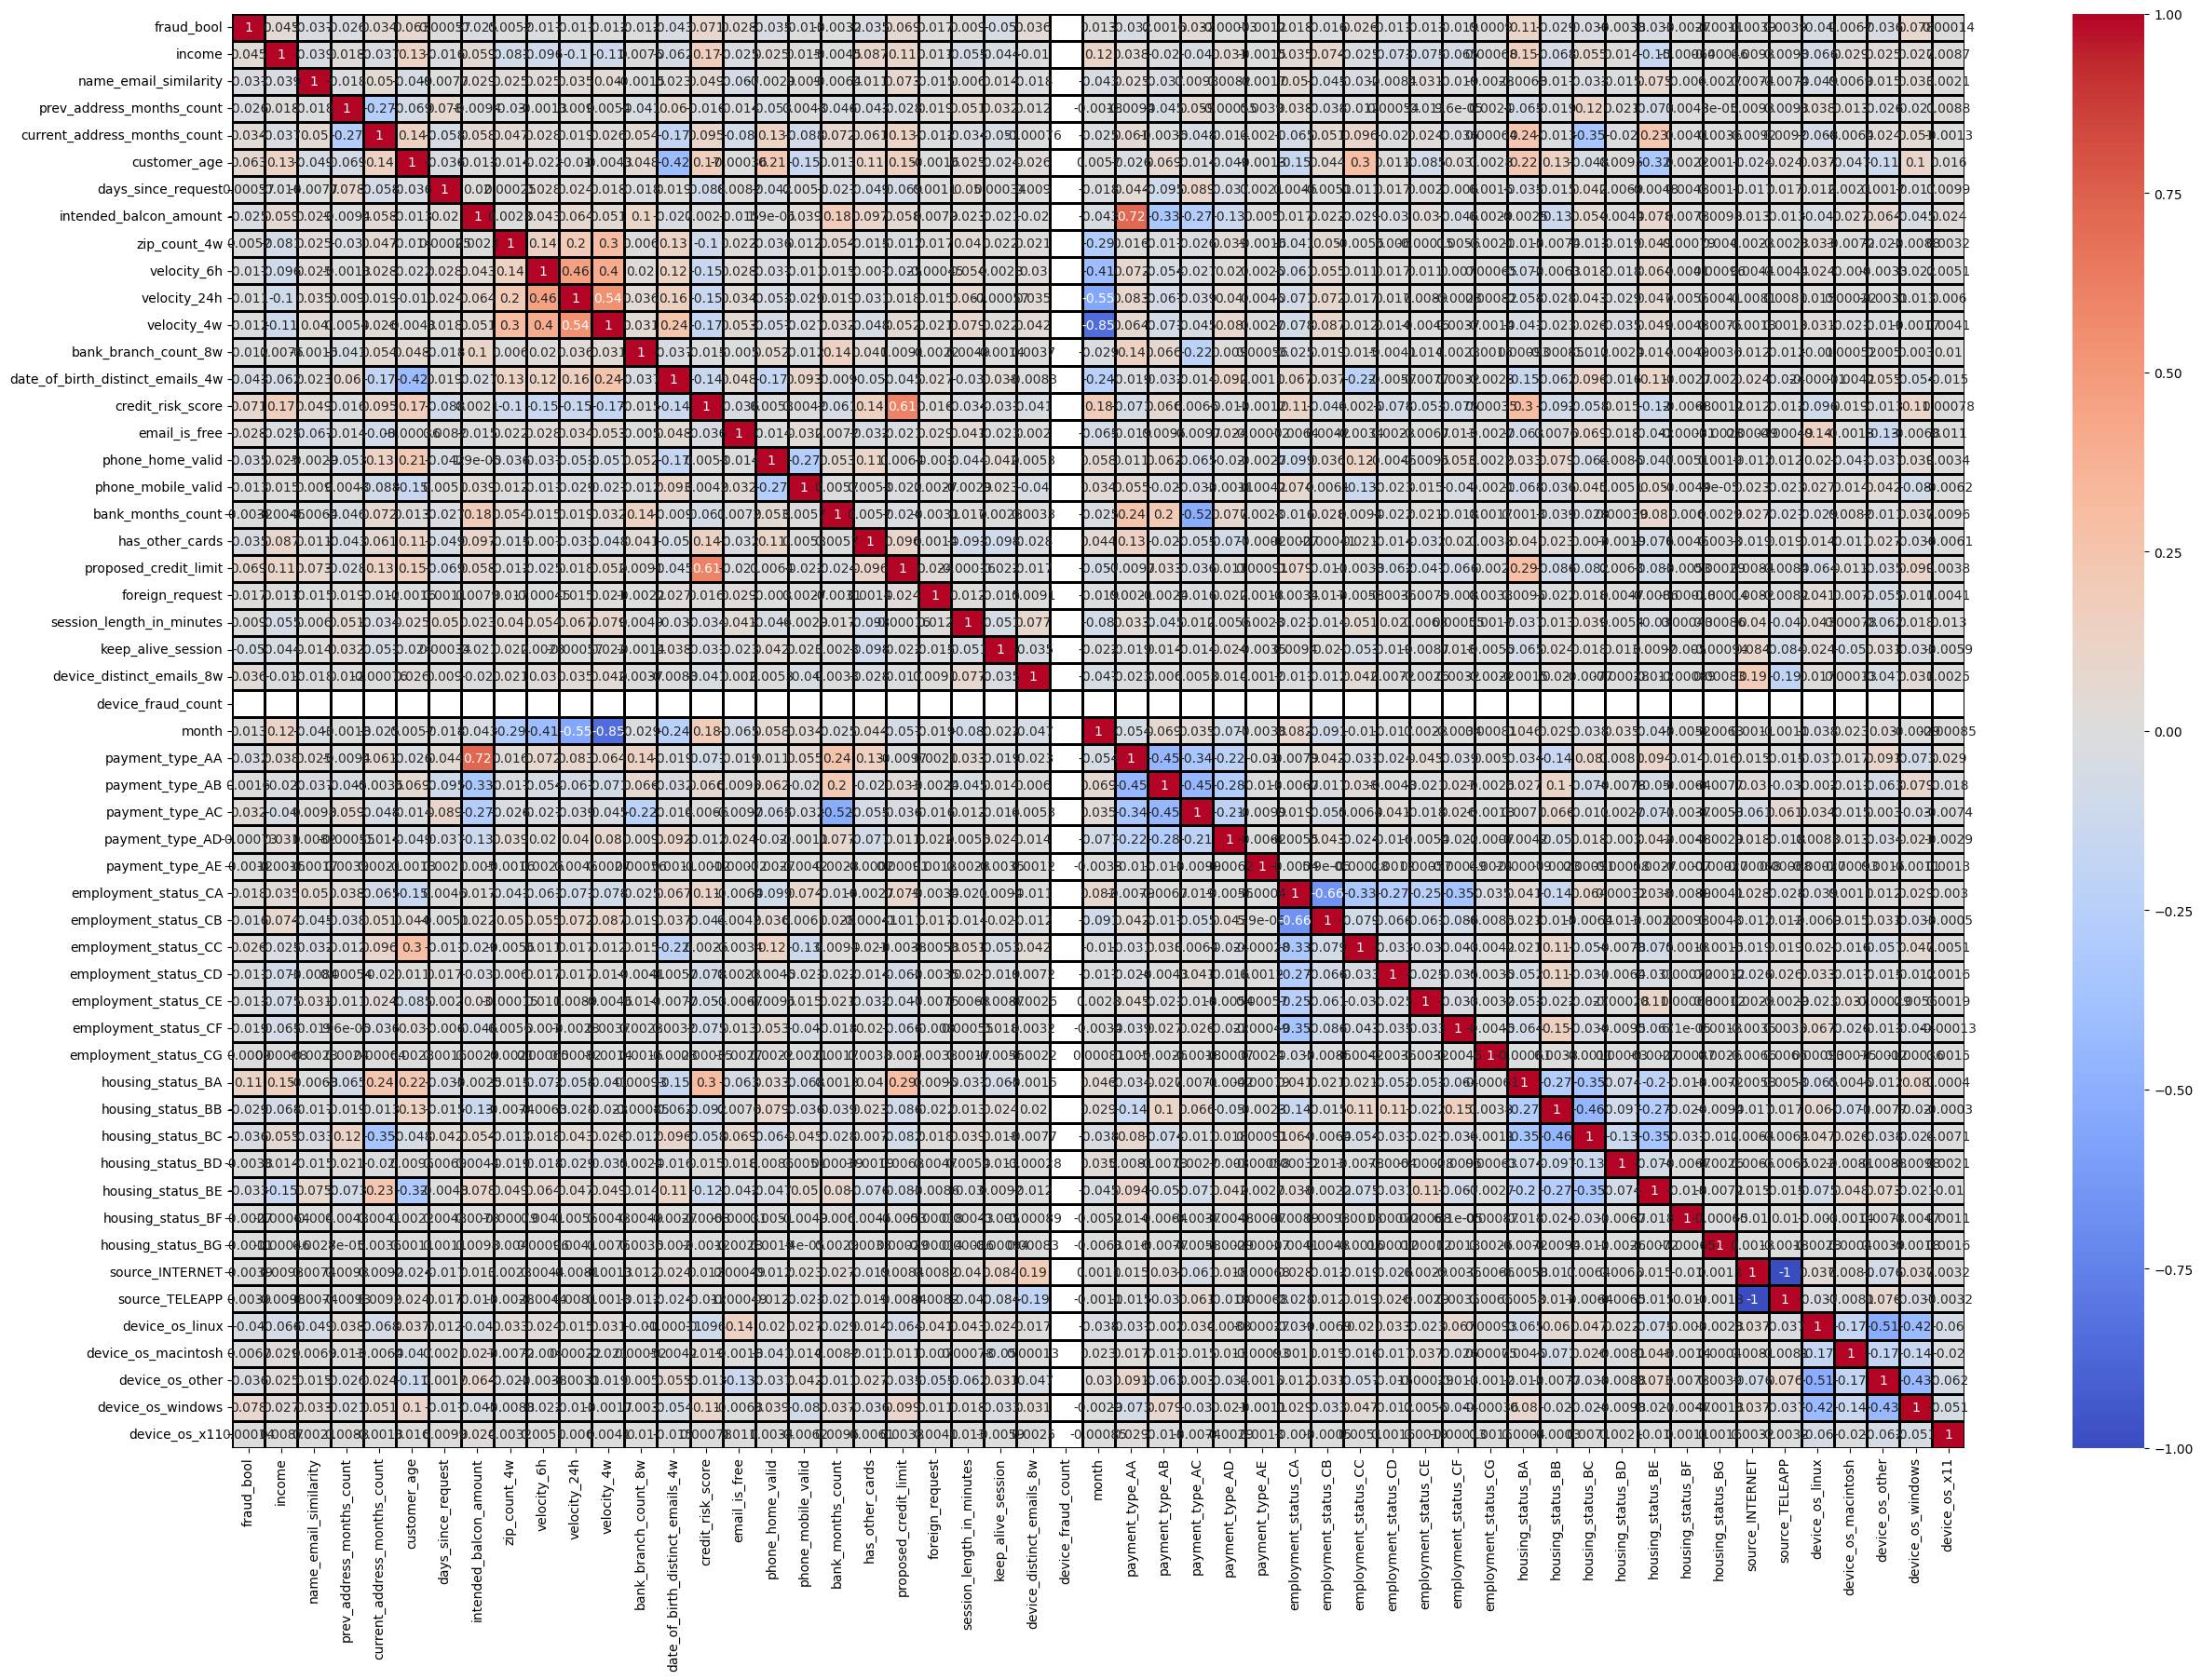

In [77]:
corr_matrix = pd.DataFrame(df).corr()
fig, ax = plt.subplots(figsize=(30,20))
sns.heatmap(corr_matrix, annot = True, vmin=-1, vmax=1, center=0, cmap= 'coolwarm', linewidths=1,linecolor='black', ax=ax)

*device_fraud_count имеет пустые ячейки так как все значения = 0, перед работой с моделью я уберу данный столбец.*

Конечно, матрица корреляции не читаема, мы можем посмотреть только цвета ячеек, которые указывают на прямую или обратную корреляцию. Посмотрим есть ли связь между целевой переменной и остальными данными:

In [82]:
df_corr = df.corr()
df_corr['fraud_bool']

fraud_bool                          1.000000
income                              0.045079
name_email_similarity              -0.036720
prev_address_months_count          -0.026031
current_address_months_count        0.033701
customer_age                        0.062959
days_since_request                  0.000567
intended_balcon_amount             -0.024524
zip_count_4w                        0.005212
velocity_6h                        -0.016892
velocity_24h                       -0.011183
velocity_4w                        -0.011536
bank_branch_count_8w               -0.011577
date_of_birth_distinct_emails_4w   -0.043224
credit_risk_score                   0.070624
email_is_free                       0.027758
phone_home_valid                   -0.035128
phone_mobile_valid                 -0.013180
bank_months_count                  -0.003222
has_other_cards                    -0.035156
proposed_credit_limit               0.068907
foreign_request                     0.016885
session_le

**В целом, значимых корреляций между целевым признаком и другими данными мы не видим.**

# 5. Сделайте промежуточный отчет-вывод по исследованию

**Какую работу мы провели:**

1. Загрузили наш датасет, проверили его на пропуски и дубликаты, посмотрели значение всех колонок
2. Провели анализ данных
3. Построили и проанализировали гистограммы
4. Перевели все данные в тип int или float
5. Посмотрели есть ли выбросы в данных
6. Построили матрицу корреляции

**Что нам удалось узнать из данных (для последующей работы):**

*   fraud_bool со значением 1 около 1.1%
*   В данных есть выбросы
*   Значимых корреляций с fraud_bool  не обнаружено, однако на гистограммах мы видим, что чаще мошенники выбирали Windows

# 6. Определите, какую задачу вы будете решать (классификация, регрессия и т.д.). Приведите метрику, с помощью которой вы будете оценивать работу вашей модели (обоснуйте ваш выбор метрики)

**Наша задача - бинарная классификация с несбалансированными классами.**

Выбранная мною метрика для сравнения моделей - ROC-AUC. ROC-кривая — графический инструмент оценки точности моделей бинарной классификации. Она позволяет найти оптимальный баланс между чувствительностью и специфичностью модели, который соответствует точке ROC-кривой, наиболее близкой к координате (0,1), в которой чувствительность и специфичность равны 1, когда ложно-положительные и ложно-отрицательные классификации отсутствуют. Критерий AUC-ROC устойчив к несбалансированным классам.

Более того, мы будем смотреть и confusion_matrix, так как нам очень важны предсказания 1 и они все должны быть определены верно.

**Каким модели мы будем "пробовать":**
*   LogisticRegression, class_weight='balanced'
*   DecisionTreeClassifier, class_weight='balanced'
*   RandomForestClassifier, class_weight='balanced'
*   StackingClassifier

А для того, чтобы проверить их все "за один раз" мы будем использовать GridSearchCV и Pipeline

# 7. Создайте несколько моделей для прогнозирования вашего целевого признака и выберите наилучшую, опираясь на вашу валидацию

Но сначала разделим наши данные на 3 выборки: тренировочную, валидационную и тестовую. Тренировочную и валидационную мы будем использовать при обучении, а на тестовой смотреть итоговую работу модели. Тренировочная будет 70%, валидационная и тестовая по 15%

In [6]:
X = df.drop(['device_fraud_count', 'fraud_bool'], axis=1)
y = df['fraud_bool']

X_train, X_test1, y_train, y_test1 = train_test_split(X, y, stratify=y, test_size=0.30, random_state=12)
X_val, X_test, y_val, y_test = train_test_split(X_test1, y_test1, stratify=y_test1, test_size=0.50, random_state=12)

Посмотрим какие классы попали в наши выборки:

In [8]:
print('Количество строк в y_train по классам [0   1]: ' , np.bincount(y_train))
print('Количество строк в y_val по классам [0   1]: ' , np.bincount(y_val))
print('Количество строк в y_test по классам [0   1]: ' , np.bincount(y_test))

Количество строк в y_train по классам [0   1]:  [692280   7720]
Количество строк в y_val по классам [0   1]:  [148346   1654]
Количество строк в y_test по классам [0   1]:  [148345   1655]


Отлично, теперь мы знаем количество у во всех выборках, перейдем к моделям. Мы не будем "пробовать" каждую по отдельности, а используем GridSearchCV чтобы перебрать как можно больше вариантов и найти среди них лучший. Так как мы уже произвели все преобразования данных, я буду использовать только StandardScaler

In [7]:
pipe = Pipeline([  
        ('scaler', StandardScaler()),
        ('classify', RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators = 100, random_state=0))
])


pipe.fit(X=X_train, y=y_train)
print('Качество модели на валидационной выборке:', {roc_auc_score(y_val, pipe.predict_proba(X_val)[:, 1])})

Качество модели на валидационной выборке: {0.8614003311908264}


In [39]:
params = [
    {'classify': [LogisticRegression(class_weight='balanced', random_state=0)]}, 

    {'classify': [DecisionTreeClassifier(class_weight='balanced', random_state=0)], 'classify__max_depth': [1, 2, 5] , 'classify__min_samples_leaf': [1, 2, 3]},

    {'classify': [RandomForestClassifier(class_weight='balanced', random_state=0)], 'classify__max_depth': [3, 4, 5], 'classify__n_estimators': [100, 150, 200], 'classify__min_samples_split': [2, 3, 4]},

    {'classify': [BaggingClassifier(DecisionTreeClassifier(class_weight='balanced', random_state=0, max_depth=2))], 'classify__n_estimators': [40, 50, 100]},

]

grid_search = GridSearchCV(pipe, param_grid=params, cv=3, scoring='roc_auc')
grid_search.fit(X=X_train, y=y_train)
print(
    'Качество модели на валидационной выборке c лучшей моделью:', 
    {roc_auc_score(y_val, grid_search.predict_proba(X_val)[:, 1])}
)

Качество модели на валидационной выборке c лучшей моделью: {0.8765590920315036}


In [40]:
grid_search.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('classify',
                 LogisticRegression(class_weight='balanced', random_state=0))])

In [41]:
df_model = pd.DataFrame.from_dict(grid_search.cv_results_).transpose()
df_2 = df_model.iloc [[9, 15]].T
df_2 = df_2.sort_values(by=['rank_test_score'])
df_2.head(10)

,params,rank_test_score
0,"{'classify': LogisticRegression(class_weight='balanced', random_state=0)}",1
32,"{'classify': RandomForestClassifier(class_weight='balanced', random_state=0), 'classify__max_depth': 5, 'classify__min_samples_split': 3, 'classify__n_estimators': 150}",2
29,"{'classify': RandomForestClassifier(class_weight='balanced', random_state=0), 'classify__max_depth': 5, 'classify__min_samples_split': 2, 'classify__n_estimators': 150}",2
35,"{'classify': RandomForestClassifier(class_weight='balanced', random_state=0), 'classify__max_depth': 5, 'classify__min_samples_split': 4, 'classify__n_estimators': 150}",2
33,"{'classify': RandomForestClassifier(class_weight='balanced', random_state=0), 'classify__max_depth': 5, 'classify__min_samples_split': 3, 'classify__n_estimators': 200}",5
36,"{'classify': RandomForestClassifier(class_weight='balanced', random_state=0), 'classify__max_depth': 5, 'classify__min_samples_split': 4, 'classify__n_estimators': 200}",5
30,"{'classify': RandomForestClassifier(class_weight='balanced', random_state=0), 'classify__max_depth': 5, 'classify__min_samples_split': 2, 'classify__n_estimators': 200}",5
34,"{'classify': RandomForestClassifier(class_weight='balanced', random_state=0), 'classify__max_depth': 5, 'classify__min_samples_split': 4, 'classify__n_estimators': 100}",8
31,"{'classify': RandomForestClassifier(class_weight='balanced', random_state=0), 'classify__max_depth': 5, 'classify__min_samples_split': 3, 'classify__n_estimators': 100}",8
28,"{'classify': RandomForestClassifier(class_weight='balanced', random_state=0), 'classify__max_depth': 5, 'classify__min_samples_split': 2, 'classify__n_estimators': 100}",8


**Лучшая модель - LogisticRegression, но все остальные после нее RandomForestClassifier:**

In [8]:
model_grid = Pipeline([  
        ('scaler', StandardScaler()),
        ('classify', LogisticRegression(class_weight='balanced', random_state=0))
])


model_grid.fit(X=X_train, y=y_train)
print('Качество модели на валидационной выборке:', {roc_auc_score(y_val, model_grid.predict_proba(X_val)[:, 1])})

Качество модели на валидационной выборке: {0.8765590920315036}


**Для себя попробуем RandomForestClassifier**

In [9]:
model_forest = Pipeline([  
        ('scaler', StandardScaler()),
        ('classify', RandomForestClassifier(class_weight='balanced', random_state=0, max_depth=5, min_samples_split=3, n_estimators=150))
])


model_forest.fit(X=X_train, y=y_train)
print('Качество модели на валидационной выборке:', {roc_auc_score(y_val, model_forest.predict_proba(X_val)[:, 1])})

Качество модели на валидационной выборке: {0.862342187911913}


**И попробуем сделать StackingClassifier из лучших моделей по версии GridSearchCV**

In [10]:
estimators = [
                ('svr', make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', random_state=0))),
                ('rf', RandomForestClassifier(class_weight='balanced', random_state=0, max_depth=5, min_samples_split=3, n_estimators=150))]

model_stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(class_weight='balanced', random_state=0))
model_stacking.fit(X_train, y_train)

print('Качество модели StackingClassifier на валидационной: ',{roc_auc_score(y_val, model_stacking.predict(X_val))})

Качество модели StackingClassifier на валидационной:  {0.8060132623051202}


**Ну и сделаем небольшую нейронную сеть, может она улучшит предсказания:**

Сначала проведем StandardScaler на наших данных:

In [11]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaler = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaler = scaler.transform(X_test)

Создадим нашу нейронную сеть:

In [12]:
def baseline_model():
    # create model
    
    model = Sequential([
        keras.layers.Dense(216, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(216, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile model
    model.compile(
        optimizer=Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model_neiro = baseline_model()

In [13]:
input_shape = X.shape  
model_neiro.build(input_shape) 
model_neiro.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1000000, 216)            11232     
                                                                 
 dropout (Dropout)           (1000000, 216)            0         
                                                                 
 dense_1 (Dense)             (1000000, 216)            46872     
                                                                 
 dropout_1 (Dropout)         (1000000, 216)            0         
                                                                 
 dense_2 (Dense)             (1000000, 1)              217       
                                                                 
Total params: 58321 (227.82 KB)
Trainable params: 58321 (227.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Создадим веса для нашей модели:

In [14]:
counts = np.bincount(y)
print('Кол-во 0 класса:', counts[0], 'Кол-во 1 класса:', counts[1])

weight_for_0 = counts[0] / 1000000
weight_for_1 = counts[1] / 1000000
print('Веса для 0 класса:', weight_for_0, ' . Веса для 0 класса:', weight_for_1)

Кол-во 0 класса: 988971 Кол-во 1 класса: 11029
Веса для 0 класса: 0.988971  . Веса для 0 класса: 0.011029


In [15]:
class_weight = {0: weight_for_0 , 1 : weight_for_1}


In [17]:
model_fit = model_neiro.fit(
    X_train_scaler,
    y_train,
    batch_size=512,
    epochs=10,
    verbose=1,
    validation_data=(X_val_scaled , y_val),
    class_weight=class_weight,
)

Epoch 1/10
1368/1368 [==============================] - 8s 6ms/step - loss: 0.0011 - accuracy: 0.9890 - val_loss: 0.0836 - val_accuracy: 0.9890
Epoch 2/10
1368/1368 [==============================] - 8s 6ms/step - loss: 0.0011 - accuracy: 0.9890 - val_loss: 0.0837 - val_accuracy: 0.9890
Epoch 3/10
1368/1368 [==============================] - 8s 6ms/step - loss: 0.0011 - accuracy: 0.9890 - val_loss: 0.0864 - val_accuracy: 0.9890
Epoch 4/10
1368/1368 [==============================] - 8s 6ms/step - loss: 0.0011 - accuracy: 0.9890 - val_loss: 0.0848 - val_accuracy: 0.9890
Epoch 5/10
1368/1368 [==============================] - 8s 6ms/step - loss: 0.0011 - accuracy: 0.9890 - val_loss: 0.0878 - val_accuracy: 0.9890
Epoch 6/10
1368/1368 [==============================] - 8s 6ms/step - loss: 0.0011 - accuracy: 0.9890 - val_loss: 0.0848 - val_accuracy: 0.9890
Epoch 7/10
1368/1368 [==============================] - 8s 6ms/step - loss: 0.0011 - accuracy: 0.9890 - val_loss: 0.0861 - val_accuracy:

Ну и сравнивать мы должны по одной метрике:

In [19]:
print('Качество модели Sequential на обучающей: ',{roc_auc_score(y_train, model_neiro.predict(X_train_scaler).ravel())})
print('Качество модели Sequential на валидационной: ',{roc_auc_score(y_val, model_neiro.predict(X_val_scaled).ravel())})

21875/21875 [==============================] - 20s 933us/step
Качество модели Sequential на обучающей:  {0.8916294567945643}
4688/4688 [==============================] - 5s 959us/step
Качество модели Sequential на валидационной:  {0.878913130649447}


# 8. Сделайте прогноз для тестовой выборки (должно быть три выборки в этой задаче: тренировочная, валидационная, тестовая)

Проверим на всех 3х моделях:

In [21]:
print('Качество модели LogisticRegression на тестовой выборке:', {roc_auc_score(y_test, model_grid.predict_proba(X_test)[:, 1])})

print('Качество модели RandomForestClassifier на тестовой выборке:', {roc_auc_score(y_test, model_forest.predict_proba(X_test)[:, 1])})

print('Качество модели StackingClassifier на тестовой выборке:', {roc_auc_score(y_test, model_stacking.predict_proba(X_test)[:, 1])})

Качество модели LogisticRegression на тестовой выборке: {0.8813370318781064}
Качество модели RandomForestClassifier на тестовой выборке: {0.8653647520238147}
Качество модели StackingClassifier на тестовой выборке: {0.8836194430819233}


In [22]:
print('Качество модели Sequential на валидационной: ',{roc_auc_score(y_test, model_neiro.predict(X_test_scaler).ravel())})

4688/4688 [==============================] - 5s 979us/step
Качество модели Sequential на валидационной:  {0.8877205611683958}


### Промежуточный вывод:
В целом LogisticRegression, StackingClassifier и Sequential отработали примерно на одном уровне, чуть хуже была модель RandomForestClassifier

**Я все таки хочу посмотреть матрицу ошибок у каждой модели**

*LogisticRegression*

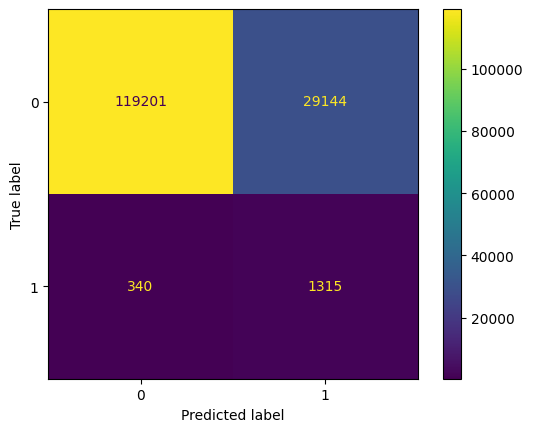

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, model_grid.predict(X_test)))
disp.plot()
plt.show()

*RandomForestClassifier*

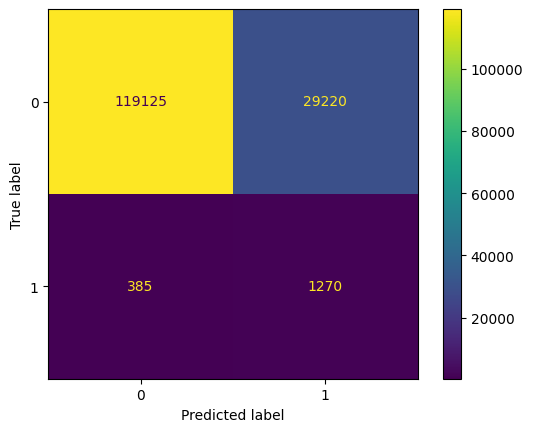

In [30]:
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, model_forest.predict(X_test)))
disp.plot()
plt.show()

*StackingClassifier*

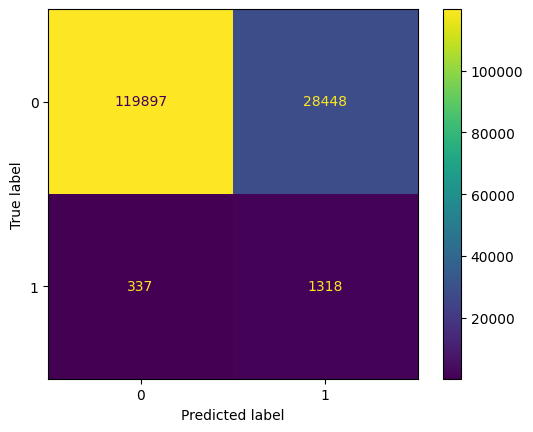

In [31]:
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, model_stacking.predict(X_test)))
disp.plot()
plt.show()

*Модель Sequential*

4688/4688 [==============================] - 4s 953us/step


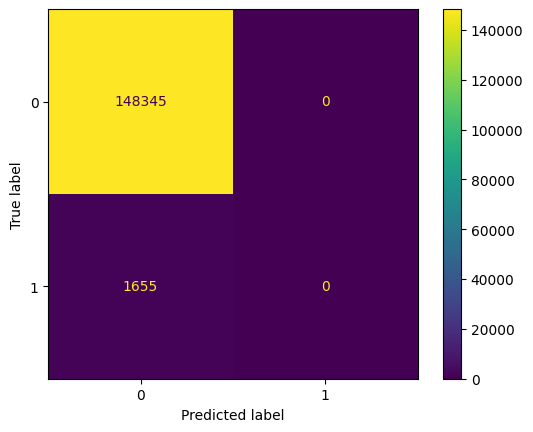

In [33]:
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, np.round(model_neiro.predict(X_test_scaler, verbose=1))))
disp.plot()
plt.show()

### Промежуточный вывод:
*   LogisticRegression - Совершила 340 ошибок (из 1655 примеров) при определении 1, т.е. ярлыка мошенничества и 29144 при определении 0 (из 148345 примеров)
*   RandomForestClassifier - Совершила 385 ошибок 1 класса и 29220 ошибок 0 класса
*   StackingClassifier - Совершила 337 ошибок 1 класса и 28448 ошибок 0 класса
*   Sequential - Просто определяла все примеры в 0 класс, т.е. вообще не нашла "ярлык мошенничества"

**И classification_report по каждой подели**

In [28]:
print('LogisticRegression')
print(classification_report(y_test, model_grid.predict(X_test)))

LogisticRegression
              precision    recall  f1-score   support

           0       1.00      0.80      0.89    148345
           1       0.04      0.79      0.08      1655

    accuracy                           0.80    150000
   macro avg       0.52      0.80      0.49    150000
weighted avg       0.99      0.80      0.88    150000



In [34]:
print('RandomForestClassifier')
print(classification_report(y_test, model_forest.predict(X_test)))

RandomForestClassifier
              precision    recall  f1-score   support

           0       1.00      0.80      0.89    148345
           1       0.04      0.77      0.08      1655

    accuracy                           0.80    150000
   macro avg       0.52      0.79      0.48    150000
weighted avg       0.99      0.80      0.88    150000



In [35]:
print('StackingClassifier')
print(classification_report(y_test, model_grid.predict(X_test)))

StackingClassifier
              precision    recall  f1-score   support

           0       1.00      0.80      0.89    148345
           1       0.04      0.79      0.08      1655

    accuracy                           0.80    150000
   macro avg       0.52      0.80      0.49    150000
weighted avg       0.99      0.80      0.88    150000



In [39]:
print('Модель Sequential')
print(classification_report(y_test, model_neiro.predict(X_test)))

Модель Sequential
4688/4688 [==============================] - 5s 982us/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    148345
           1       0.00      0.00      0.00      1655

    accuracy                           0.99    150000
   macro avg       0.49      0.50      0.50    150000
weighted avg       0.98      0.99      0.98    150000



c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### Промежуточный вывод:
В целом, classification_report подтверждает выводы после ConfusionMatrixDisplay

**Ну и чтобы ответить на последний вопрос, создадим dummy-модель**

In [42]:
def dum_model(features):
    return [np.random.random() for item in range(len(features))]

dum_pred_train = dum_model(X_train)
dum_pred_val = dum_model(X_val)
dum_pred_test = dum_model(X_test)

In [44]:
roc_auc_dum_train = roc_auc_score(y_train, dum_pred_train)
roc_auc_dum_val = roc_auc_score(y_val, dum_pred_val)
roc_auc_dum_test = roc_auc_score(y_test, dum_pred_test)

print(f'ROC-AUC на тренировочной {roc_auc_dum_train}')
print(f'ROC-AUC на валидационной {roc_auc_dum_val}')
print(f'ROC-AUC на тестовой {roc_auc_dum_test}')

ROC-AUC на тренировочной 0.4976778736088995
ROC-AUC на валидационной 0.4892345945508516
ROC-AUC на тестовой 0.5157549799963118


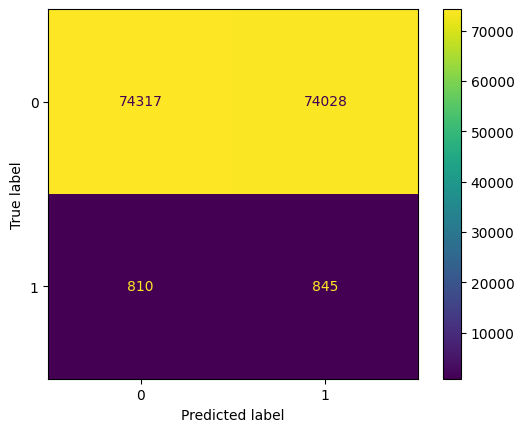

In [47]:
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, np.round(dum_pred_test)))
disp.plot()
plt.show()

В целом, все правильно 50/50

# 9. Сделайте вывод о работе вашей модели и метриках. Обоснуйте: «Нужно ли использовать для решения этой задачи машинное обучение или можно обойтись dummy-предсказанием?»

Какую работу мы провели:
*   Загрузили и проанализировали датасет
*   Посмотрели модели, используя Pipeline и GridSearchCV
*   Создали и проанализировали результаты 4-х моделей: LogisticRegression, RandomForestClassifier, StackingClassifier и Sequential модель

Сначала определим лучшую модель, опираясь на roc_auc и confusion_matrix - **LogisticRegression** и **StackingClassifier**. Почему:
*   Высокие показатели roc_auc: LogisticRegression 0.88 и StackingClassifier 0.88
*   Наименьшее количество ошибок при определении 1 класса: LogisticRegression 340 (20.54%) и StackingClassifier 337 (20.36%) из 1655 примеров

Они находятся практически на одном уровне, поэтому я обе определила в лучшие.

RandomForestClassifier имеет и roc_auc ниже и большее количество ошибок, Sequential-модель вообще не нашла 1 класс, хотя roc_auc на уровне 0.89. Это может происходить потому, что у нас маленькое количество примеров 1 класса и нет очевидных корреляций между целевым признаком и остальным датасетом

**Отвечая на вопрос про dummy-модель: Конечно без машинного обучения в этой задаче не обойтись, так как dummy-модель условно "случайно" определяет классы, а модели "ищут" закономерности в данных.**